In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E56CFFB518>, 'tobs': 65.0, 'date': '2010-01-01', 'id': 1, 'prcp': 0.08, 'station': 'USC00519397'}


The latest Measurement data is available for date 2017-08-23 and total number of rows = 19550


Analysis being done for the following timeframe 
Start Date = 2016-08-23 00:00:00
Ending Date = 2017-08-23 00:00:00


First 10 rows fetched from resultset

2016-08-24, 0.08
2016-08-25, 0.08
2016-08-26, 0.0
2016-08-27, 0.0
2016-08-28, 0.01
2016-08-29, 0.0
2016-08-30, 0.0
2016-08-31, 0.13
2016-09-01, 0.0
2016-09-02, 0.0


After fetching the resultset into DataFrame
         date  prcp
0  2016-08-24  0.08
1  2016-08-25  0.08
2  2016-08-26  0.00
3  2016-08-27  0.00
4  2016-08-28  0.01


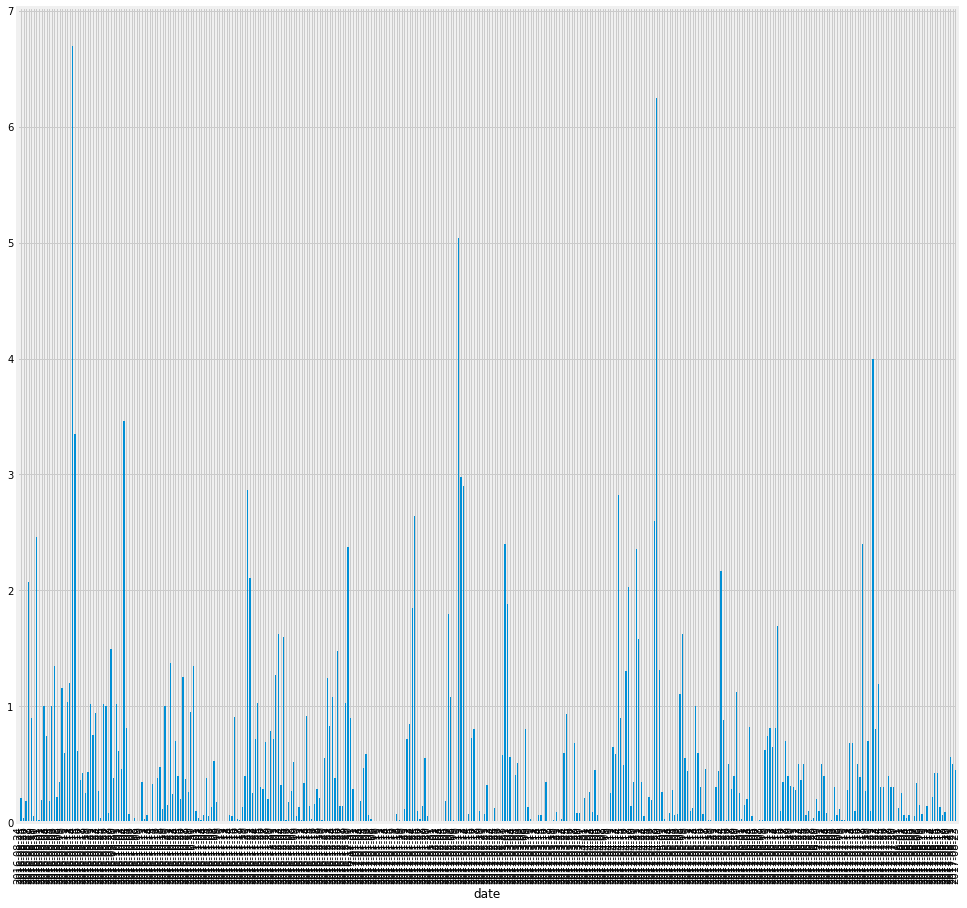

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first_row = session.query(Measurement).first()
print(first_row.__dict__)
## Identify the last row of data in Measurement table
for row in session.query(func.max(Measurement.date), func.count(Measurement.id)):
    print(f"\n\nThe latest Measurement data is available for date {row[0]} and total number of rows = {row[1]}")

## Identify the starting timeframe and ending timeframe for analysis
end_dt = dt.datetime(2017, 8, 23)

# Calculate the date 1 year ago from the last data point in the database
start_dt = end_dt - dt.timedelta(days = 365)

print(f"\n\nAnalysis being done for the following timeframe \nStart Date = {start_dt}\nEnding Date = {end_dt}")

# Perform a query to retrieve the data and precipitation scores
resultset = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(start_dt, end_dt)).all()
print("\n\nFirst 10 rows fetched from resultset\n")
for id, result in enumerate(resultset):
    if id >= 10:
        break
    else:
        print(f"{result.date}, {result.prcp}")

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(start_dt, end_dt)).statement, session.bind)
print("\n\nAfter fetching the resultset into DataFrame")
print(df.head())
df = df.groupby("date").max()
df.head()

df.plot(kind="bar", figsize = [15,15], legend=False)
plt.savefig("date_prcp.png")

![precipitation](Images/precipitation.png)

In [41]:
df.describe()

,prcp
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [47]:
# Design a query to show how many stations are available in this dataset?
first_row=session.query(Station).first()
print(first_row.__dict__)

for row in session.query(func.count(Station.id)):
    print(f"\n\nThere are a total of {row[0]} stations in the data set")

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E56CFFB470>, 'elevation': 3.0, 'latitude': 21.2716, 'station': 'USC00519397', 'id': 1, 'longitude': -157.8168, 'name': 'WAIKIKI 717.2, HI US'}


There are a total of 9 stations in the data set


In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for row in session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()):
    print(row[0], row[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
for row in session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.AVG(Measurement.tobs)):
    print(row)

(53.0, 87.0, 73.09795396419437)


In [71]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station="USC00519281"
station_df=pd.read_sql(session.query(Measurement.tobs).filter(Measurement.date.between(start_dt, end_dt)).statement, session.bind)
station_df.count()

tobs    2223
dtype: int64

In [82]:
station_df.head()
station_df.dtypes

tobs    float64
dtype: object

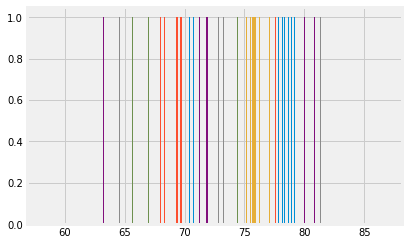

In [81]:
plt.hist(station_df, bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


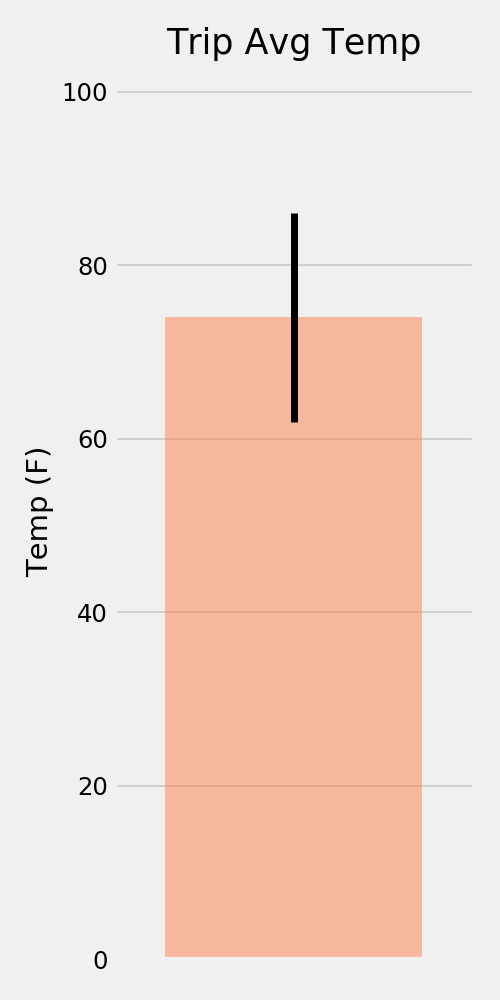

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


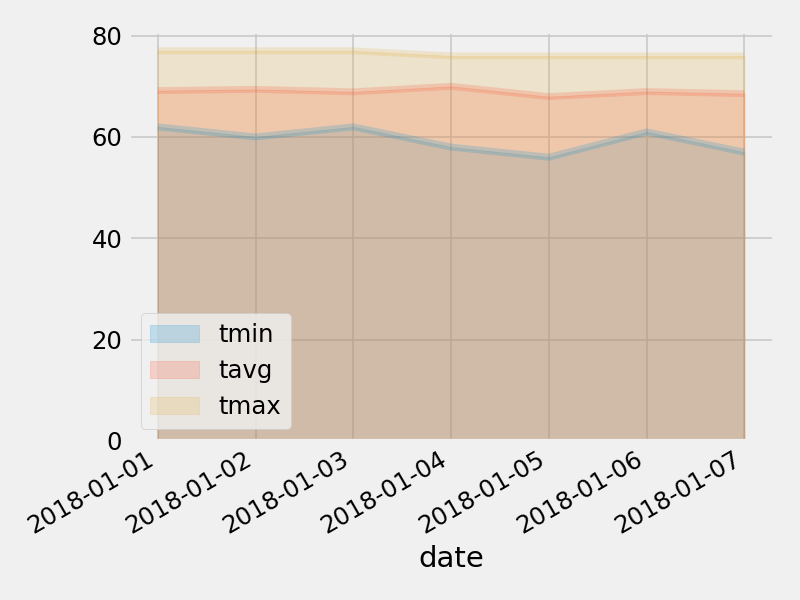

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
